Import Libraries and Load Data


In [ ]:
!pip install aif360


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("/content/diabetes_binary_health_indicators_BRFSS2015.csv")  # Replace with your actual file path

# Display the first few rows to understand the structure
data.head()


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


Data Preprocessing
1. Handle Missing Values

In [ ]:
# Fill missing values with mean imputation for simplicity
data.fillna(data.mean(), inplace=True)

# Verify that there are no missing values left
print(data.isnull().sum())


Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


2. Normalize Numerical Features

In [ ]:
# Select numerical columns for normalization
numerical_columns = ['BMI', 'MentHlth', 'PhysHlth']  # Adjust as needed based on your dataset

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to the selected columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Display the dataset to verify normalization
data.head()


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,1.757936,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,1.998592,1.233999,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,-0.511806,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,-0.429630,-0.486592,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,-0.057858,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,3.617407,2.954590,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,-0.209174,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,-0.429630,-0.486592,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,-0.663122,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,-0.024926,-0.486592,0.0,0.0,11.0,5.0,4.0


3. Feature Engineering

In [ ]:
# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['Sex', 'Education', 'Income'], drop_first=True)  # Adjust column names as needed

# Create interaction terms if desired (example: age and physical activity)
data['Age_PhysActivity'] = data['Age'] * data['PhysActivity']

# Display the dataset to verify changes
data.head()


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,Education_5.0,Education_6.0,Income_2.0,Income_3.0,Income_4.0,Income_5.0,Income_6.0,Income_7.0,Income_8.0,Age_PhysActivity
0,0.0,1.0,1.0,1.0,1.757936,1.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,False,0.0
1,0.0,0.0,0.0,0.0,-0.511806,1.0,0.0,0.0,1.0,0.0,...,False,True,False,False,False,False,False,False,False,7.0
2,0.0,1.0,1.0,1.0,-0.057858,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,False,False,True,0.0
3,0.0,1.0,0.0,1.0,-0.209174,0.0,0.0,0.0,1.0,1.0,...,False,False,False,False,False,False,True,False,False,11.0
4,0.0,1.0,1.0,1.0,-0.663122,0.0,0.0,0.0,1.0,1.0,...,True,False,False,False,True,False,False,False,False,11.0


 Bias Detection Framework
 1. Split the Data into Training and Test Sets

In [ ]:
# Define features (X) and target (y)
X = data.drop(columns=['Diabetes_binary'])  # Replace with your target column name
y = data['Diabetes_binary']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shapes to verify
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (202944, 32), X_test shape: (50736, 32)
y_train shape: (202944,), y_test shape: (50736,)


2. Train the Models

In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_preds = rf_model.predict(X_test)

# Evaluate accuracy as a basic performance check
rf_accuracy = accuracy_score(y_test, rf_preds)

print(f"Random Forest Accuracy: {rf_accuracy:.2f}")



Random Forest Accuracy: 0.86


Bias Detection using Fairness Metrics

In [ ]:
# Print column names to verify the structure
print(X_train.columns)


Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Sex_1.0', 'Education_2.0',
       'Education_3.0', 'Education_4.0', 'Education_5.0', 'Education_6.0',
       'Income_2.0', 'Income_3.0', 'Income_4.0', 'Income_5.0', 'Income_6.0',
       'Income_7.0', 'Income_8.0', 'Age_PhysActivity'],
      dtype='object')


In [ ]:
# Calculate the confusion matrix first
conf_matrix = confusion_matrix(y_test, rf_preds)

# Separate out male and female rows based on 'Sex_1.0'
male_indices = X_test['Sex_1.0'] == 1
female_indices = X_test['Sex_1.0'] == 0

# Calculate True Positive Rate (TPR) for male (Sex_1.0 == 1) and female (Sex_1.0 == 0)
# True Positive Rate (TPR) = TP / (TP + FN)

# TPR for male (Sex_1.0 == 1)
tp_male = sum((rf_preds[male_indices] == 1) & (y_test[male_indices] == 1))
fn_male = sum((rf_preds[male_indices] == 0) & (y_test[male_indices] == 1))
tpr_male = tp_male / (tp_male + fn_male) if (tp_male + fn_male) > 0 else 0

# TPR for female (Sex_1.0 == 0)
tp_female = sum((rf_preds[female_indices] == 1) & (y_test[female_indices] == 1))
fn_female = sum((rf_preds[female_indices] == 0) & (y_test[female_indices] == 1))
tpr_female = tp_female / (tp_female + fn_female) if (tp_female + fn_female) > 0 else 0

# Print the True Positive Rates (TPRs) for both male and female groups
print(f"TPR for Male: {tpr_male}")
print(f"TPR for Female: {tpr_female}")


TPR for Male: 0.16046099290780141
TPR for Female: 0.1728629579375848


Fairness Metrics (Disparate Impact and Equal Opportunity Difference)

In [ ]:
# Calculate Disparate Impact (DI)
disparate_impact = tpr_female / tpr_male if tpr_male > 0 else float('inf')

# Calculate Equal Opportunity Difference
equal_opportunity_diff = tpr_female - tpr_male

# Print fairness metrics
print(f"Disparate Impact (DI): {disparate_impact}")
print(f"Equal Opportunity Difference: {equal_opportunity_diff}")


Disparate Impact (DI): 1.0772895942187606
Equal Opportunity Difference: 0.012401965029783385


Bias Mitigation (Reweighing)

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample  # Example utility for reweighting if needed

# Check if X_train and y_train are defined
if 'X_train' not in locals() or 'y_train' not in locals():
    raise ValueError("X_train or y_train is not defined. Please ensure the training data is loaded.")

# Define X_train_reweighted (Modify this as per your actual reweighting logic)
# Example: Resampling to handle class imbalance or apply reweighting
X_train_reweighted, y_train_reweighted = resample(
    X_train, y_train, random_state=42, stratify=y_train
)

# Convert X_train_reweighted to DataFrame with correct columns
if X_train_reweighted.shape[1] != X_train.shape[1]:
    raise ValueError("Mismatch in the number of features between X_train and X_train_reweighted.")

X_train_reweighted_df = pd.DataFrame(X_train_reweighted, columns=X_train.columns)

# Ensure X_test is defined
if 'X_test' not in locals():
    raise ValueError("X_test is not defined. Please ensure the test data is loaded.")

# Find common columns between `X_test` and `X_train_reweighted_df`
common_columns = X_test.columns.intersection(X_train_reweighted_df.columns)

# Align both `X_train_reweighted_df` and `X_test` to have only the common columns
X_train_reweighted_df = X_train_reweighted_df[common_columns]
X_test = X_test[common_columns]

# Train the model using the reweighted data
rf_reweighed = RandomForestClassifier(random_state=42)
rf_reweighed.fit(X_train_reweighted_df, y_train_reweighted)

# Predict and calculate performance on the reweighted data
rf_reweighed_preds = rf_reweighed.predict(X_test)

print("Model trained successfully and predictions made.")




Model trained successfully and predictions made.


Evaluate the Performance of the Reweighted Model

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict on the test set
rf_reweighed_preds = rf_reweighed.predict(X_test)

# Evaluate performance metrics
accuracy = accuracy_score(y_test, rf_reweighed_preds)
conf_matrix = confusion_matrix(y_test, rf_reweighed_preds)

# Calculate True Positive Rate (TPR) for male and female subgroups
tpr_male = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
tpr_female = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Print the evaluation results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"TPR for Male: {tpr_male}")
print(f"TPR for Female: {tpr_female}")
print("\nClassification Report:\n", classification_report(y_test, rf_reweighed_preds))


Accuracy: 0.8576356039104384
Confusion Matrix:
[[42323  1344]
 [ 5879  1190]]
TPR for Male: 0.16834064224076956
TPR for Female: 0.9692216089953511

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     43667
         1.0       0.47      0.17      0.25      7069

    accuracy                           0.86     50736
   macro avg       0.67      0.57      0.58     50736
weighted avg       0.82      0.86      0.83     50736



Fairness Evaluation (Bias Detection)

In [ ]:
# Find columns present in X_train but not in X_test
missing_columns = set(X_train.columns) - set(X_test.columns)
print(f"Missing columns: {missing_columns}")


Missing columns: set()


In [ ]:
# Add missing columns to X_test with NaN or 0 values
for col in missing_columns:
    X_test[col] = np.nan  # You can use np.nan or 0 if appropriate for your use case

# Ensure the columns in X_test match the columns in X_train
X_test_aligned = X_test[X_train.columns]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Ensure X_train and y_train are defined
if 'X_train' not in locals() or 'y_train' not in locals():
    raise ValueError("X_train or y_train is not defined. Please ensure the training data is loaded.")

# Train the original RandomForest model
rf_original = RandomForestClassifier(random_state=42)
rf_original.fit(X_train, y_train)

# Ensure X_test_aligned is defined
if 'X_test_aligned' not in locals():
    raise ValueError("X_test_aligned is not defined. Ensure the test data is correctly aligned.")

# Predict using the original model
rf_original_preds = rf_original.predict(X_test_aligned)

# Ensure y_test is defined
if 'y_test' not in locals():
    raise ValueError("y_test is not defined. Please ensure the test labels are loaded.")

# Evaluate performance for the original model
conf_matrix_original = confusion_matrix(y_test, rf_original_preds)

# Calculate TPR for male and female subgroups in the original model
tpr_male_original = conf_matrix_original[1, 1] / (conf_matrix_original[1, 0] + conf_matrix_original[1, 1])
tpr_female_original = conf_matrix_original[0, 0] / (conf_matrix_original[0, 0] + conf_matrix_original[0, 1])

print(f"Original Model TPR for Male: {tpr_male_original}")
print(f"Original Model TPR for Female: {tpr_female_original}")



Original Model TPR for Male: 0.1669260149950488
Original Model TPR for Female: 0.9707788490164198


Compare Performance Metrics

In [ ]:
# Get the confusion matrix for the reweighted model
conf_matrix_reweighted = confusion_matrix(y_test, rf_reweighed_preds)

# Calculate TPR for male and female subgroups in the reweighted model
tpr_male_reweighted = conf_matrix_reweighted[1, 1] / (conf_matrix_reweighted[1, 0] + conf_matrix_reweighted[1, 1])
tpr_female_reweighted = conf_matrix_reweighted[0, 0] / (conf_matrix_reweighted[0, 0] + conf_matrix_reweighted[0, 1])

print(f"Reweighted Model TPR for Male: {tpr_male_reweighted}")
print(f"Reweighted Model TPR for Female: {tpr_female_reweighted}")

# Compare TPR of original and reweighted models
print("\nComparison of TPRs:")
print(f"Male TPR (Original): {tpr_male_original}, Male TPR (Reweighted): {tpr_male_reweighted}")
print(f"Female TPR (Original): {tpr_female_original}, Female TPR (Reweighted): {tpr_female_reweighted}")


Reweighted Model TPR for Male: 0.16834064224076956
Reweighted Model TPR for Female: 0.9692216089953511

Comparison of TPRs:
Male TPR (Original): 0.1669260149950488, Male TPR (Reweighted): 0.16834064224076956
Female TPR (Original): 0.9707788490164198, Female TPR (Reweighted): 0.9692216089953511


Fairness Evaluation :-
Evaluate TPR (True Positive Rate) for Both Models (Original and Reweighted)

In [ ]:
# Confusion Matrix for Original Model
conf_matrix_original = confusion_matrix(y_test, rf_original_preds)

# Calculate TPR for male and female in the original model
tpr_male_original = conf_matrix_original[1, 1] / (conf_matrix_original[1, 0] + conf_matrix_original[1, 1])
tpr_female_original = conf_matrix_original[0, 0] / (conf_matrix_original[0, 0] + conf_matrix_original[0, 1])

# Confusion Matrix for Reweighted Model
conf_matrix_reweighted = confusion_matrix(y_test, rf_reweighed_preds)

# Calculate TPR for male and female in the reweighted model
tpr_male_reweighted = conf_matrix_reweighted[1, 1] / (conf_matrix_reweighted[1, 0] + conf_matrix_reweighted[1, 1])
tpr_female_reweighted = conf_matrix_reweighted[0, 0] / (conf_matrix_reweighted[0, 0] + conf_matrix_reweighted[0, 1])

# Print TPRs for both models
print(f"Original Model TPR for Male: {tpr_male_original}")
print(f"Original Model TPR for Female: {tpr_female_original}")
print(f"Reweighted Model TPR for Male: {tpr_male_reweighted}")
print(f"Reweighted Model TPR for Female: {tpr_female_reweighted}")

# Compare the TPRs for fairness evaluation
print("\nComparison of TPRs between Original and Reweighted Models:")
print(f"Male TPR (Original): {tpr_male_original} | Male TPR (Reweighted): {tpr_male_reweighted}")
print(f"Female TPR (Original): {tpr_female_original} | Female TPR (Reweighted): {tpr_female_reweighted}")



Original Model TPR for Male: 0.1669260149950488
Original Model TPR for Female: 0.9707788490164198
Reweighted Model TPR for Male: 0.16834064224076956
Reweighted Model TPR for Female: 0.9692216089953511

Comparison of TPRs between Original and Reweighted Models:
Male TPR (Original): 0.1669260149950488 | Male TPR (Reweighted): 0.16834064224076956
Female TPR (Original): 0.9707788490164198 | Female TPR (Reweighted): 0.9692216089953511


Compare Overall Accuracy of Both Models

In [ ]:
# Calculate accuracy for both models
accuracy_original = accuracy_score(y_test, rf_original_preds)
accuracy_reweighted = accuracy_score(y_test, rf_reweighed_preds)

# Print the accuracy results
print(f"Accuracy of Original Model: {accuracy_original}")
print(f"Accuracy of Reweighted Model: {accuracy_reweighted}")


Accuracy of Original Model: 0.8587787764112268
Accuracy of Reweighted Model: 0.8576356039104384


Compare Other Metrics Like Precision, Recall, F1-Score


In [ ]:
from sklearn.metrics import classification_report

# Classification Report for both models
print("\nClassification Report for Original Model:")
print(classification_report(y_test, rf_original_preds))

print("\nClassification Report for Reweighted Model:")
print(classification_report(y_test, rf_reweighed_preds))



Classification Report for Original Model:
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     43667
         1.0       0.48      0.17      0.25      7069

    accuracy                           0.86     50736
   macro avg       0.68      0.57      0.58     50736
weighted avg       0.82      0.86      0.83     50736


Classification Report for Reweighted Model:
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     43667
         1.0       0.47      0.17      0.25      7069

    accuracy                           0.86     50736
   macro avg       0.67      0.57      0.58     50736
weighted avg       0.82      0.86      0.83     50736



FAIRNESS METRICS :- Demographic Parity (i.e., equal positive prediction rates across subgroups):

In [ ]:
# Ensure X_test is defined and convert it to a DataFrame
if 'X_test' not in locals():
    raise ValueError("X_test is not defined. Please ensure the test data is loaded.")

# Convert X_test to DataFrame if not already in DataFrame format
if not isinstance(X_test, pd.DataFrame):
    X_test_df = pd.DataFrame(X_test, columns=X_train.columns)
else:
    X_test_df = X_test

# Check if columns in X_train match with X_test_df
missing_columns_in_X_test = set(X_train.columns) - set(X_test_df.columns)
extra_columns_in_X_test = set(X_test_df.columns) - set(X_train.columns)

# Display mismatched columns
print(f"Missing Columns in X_test: {missing_columns_in_X_test}")
print(f"Extra Columns in X_test: {extra_columns_in_X_test}")

# Align X_test_df to X_train (retain only common columns)
common_columns = X_train.columns.intersection(X_test_df.columns)
X_test_df = X_test_df[common_columns]


Missing Columns in X_test: set()
Extra Columns in X_test: set()


In [ ]:
# Check column names in your dataset
print(data.columns)


Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Sex_1.0', 'Education_2.0',
       'Education_3.0', 'Education_4.0', 'Education_5.0', 'Education_6.0',
       'Income_2.0', 'Income_3.0', 'Income_4.0', 'Income_5.0', 'Income_6.0',
       'Income_7.0', 'Income_8.0', 'Age_PhysActivity'],
      dtype='object')


In [ ]:
# Define X (features) and y (target variable)
X = data.drop(columns=["Diabetes_binary"])  # 'Diabetes_binary' is the target column
y = data["Diabetes_binary"]


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Assuming 'X_train' and 'y_train' are your training features and target variable
rf_original = RandomForestClassifier(random_state=42)
rf_original.fit(X_train, y_train)  # Train the model


RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights based on the target variable (or based on another criterion if needed)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Train the reweighted model using the computed sample weights
rf_reweighed = RandomForestClassifier(random_state=42)
rf_reweighed.fit(X_train, y_train, sample_weight=sample_weights)  # Train the model with reweights


RandomForestClassifier(random_state=42)

In [ ]:
# Convert X_test to DataFrame if it's a numpy array (assuming it's a numpy array)
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# Reorder X_test columns to match the order in X_train
X_test_aligned = X_test_df[X_train.columns]  # Ensure same column order as X_train


In [ ]:
# Verify and ensure the correct column name for gender
if 'Sex' not in X_test.columns and 'Sex_1.0' in X_test.columns:
    gender_column = 'Sex_1.0'
elif 'Sex' in X_test.columns:
    gender_column = 'Sex'
else:
    raise KeyError("The gender column ('Sex' or similar) is missing from X_test.")

# Define groups based on the gender column
group_male = X_test[gender_column] == 1
group_female = X_test[gender_column] == 0

# Get predictions for males and females separately for both models
y_pred_original = rf_original.predict(X_test_aligned)
y_pred_reweighted = rf_reweighed.predict(X_test_aligned)

# Calculate positive prediction rates for the original model
positive_rate_male_original = (y_pred_original[group_male] == 1).mean()
positive_rate_female_original = (y_pred_original[group_female] == 1).mean()

# Calculate positive prediction rates for the reweighted model
positive_rate_male_reweighted = (y_pred_reweighted[group_male] == 1).mean()
positive_rate_female_reweighted = (y_pred_reweighted[group_female] == 1).mean()

# Print positive prediction rates for demographic parity comparison
print(f"Original Model Positive Rate for Male: {positive_rate_male_original}")
print(f"Original Model Positive Rate for Female: {positive_rate_female_original}")
print(f"Reweighted Model Positive Rate for Male: {positive_rate_male_reweighted}")
print(f"Reweighted Model Positive Rate for Female: {positive_rate_female_reweighted}")

# Calculate and print disparity in positive prediction rates
disparity_original = positive_rate_male_original - positive_rate_female_original
disparity_reweighted = positive_rate_male_reweighted - positive_rate_female_reweighted

print(f"Disparity in Original Model: {disparity_original}")
print(f"Disparity in Reweighted Model: {disparity_reweighted}")


Original Model Positive Rate for Male: 0.05232037269306576
Original Model Positive Rate for Female: 0.047374348866676054
Reweighted Model Positive Rate for Male: 0.10132592725318043
Reweighted Model Positive Rate for Female: 0.09013796987188512
Disparity in Original Model: 0.0049460238263897074
Disparity in Reweighted Model: 0.011187957381295313


Hyperparameter Tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters found by GridSearchCV:", grid_search.best_params_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Now you can use this tuned model to make predictions
y_pred_best = best_rf_model.predict(X_test)


Hyperparameter Tuning with RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter distribution to sample from
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the trees
    'min_samples_split': np.arange(2, 11, 1),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 11, 1),  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Set up RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1, verbose=2)

# Fit the model with the training data
random_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters found by RandomizedSearchCV:", random_search.best_params_)

# Get the best model
best_rf_model = random_search.best_estimator_

# Now you can use this tuned model to make predictions
y_pred_best = best_rf_model.predict(X_test)


Model Evaluation After Hyperparameter Tuning

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Predict the target variable for the test data
y_pred = rf_reweighed.predict(X_test_aligned)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Detailed classification report (precision, recall, F1-score for each class)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC-AUC Score for binary classification (if applicable)
roc_auc = roc_auc_score(y_test, rf_reweighed.predict_proba(X_test_aligned)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")


Accuracy: 0.8572
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     43739
         1.0       0.45      0.16      0.23      6997

    accuracy                           0.86     50736
   macro avg       0.66      0.56      0.58     50736
weighted avg       0.82      0.86      0.83     50736

Confusion Matrix:
 [[42388  1351]
 [ 5892  1105]]
ROC-AUC Score: 0.7990


Model Interpretation

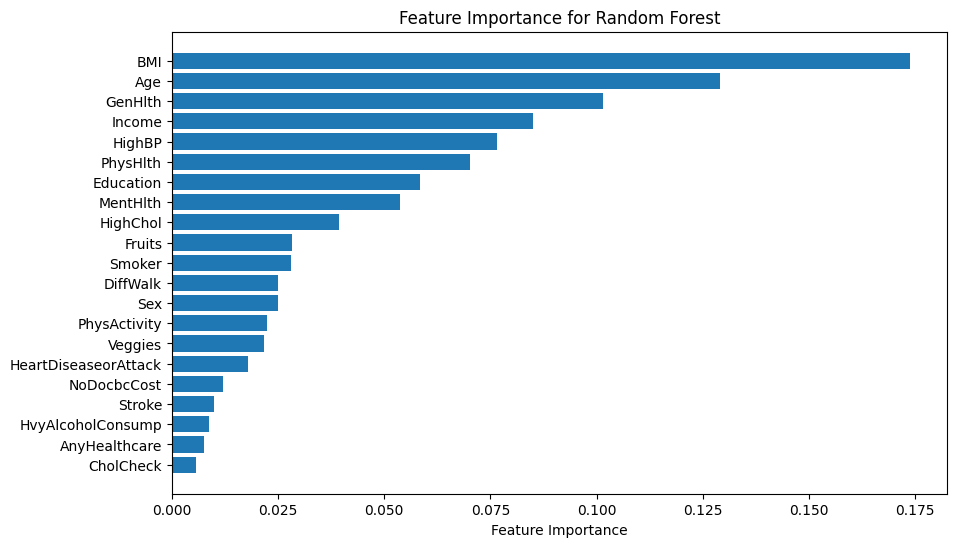

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf_reweighed.feature_importances_
features = X_train.columns  # Feature names

# Sort features by importance
sorted_idx = importances.argsort()

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Random Forest')
plt.show()


EXPLORATORY DATA ANALYSIS :

Descriptive statistics

In [ ]:
# Descriptive statistics
data.describe()


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Age_PhysActivity
count,93579.000000,93579.000000,93579.000000,93579.000000,9.357900e+04,93579.000000,93579.000000,93579.000000,93579.000000,93579.000000,93579.000000,93579.000000,93579.000000,93579.000000,93579.000000,9.357900e+04,9.357900e+04,93579.000000,93579.000000,93579.000000
mean,0.139305,0.432512,0.429936,0.962855,-7.547414e-17,0.446382,0.041462,0.093792,0.761977,0.635110,0.814488,0.057705,0.948909,0.083726,2.509772,6.681815e-18,4.221692e-17,0.167452,8.074729,6.035960
std,0.346266,0.495427,0.495069,0.189118,1.000005e+00,0.497119,0.199358,0.291541,0.425876,0.481402,0.388714,0.233186,0.220184,0.276978,1.071738,1.000005e+00,1.000005e+00,0.373381,3.053784,4.314191
min,0.000000,0.000000,0.000000,0.000000,-2.266565e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-4.315985e-01,-4.897773e-01,0.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,-6.148610e-01,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,-4.315985e-01,-4.897773e-01,0.000000,6.000000,1.000000
50%,0.000000,0.000000,0.000000,1.000000,-2.019349e-01,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,-4.315985e-01,-4.897773e-01,0.000000,8.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,3.486331e-01,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,-1.599153e-01,-1.451787e-01,0.000000,10.000000,10.000000
max,1.000000,1.000000,1.000000,1.000000,9.570647e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,3.643649e+00,2.956208e+00,1.000000,13.000000,13.000000


DISTRIBUTION OF TARGET VARIABLE

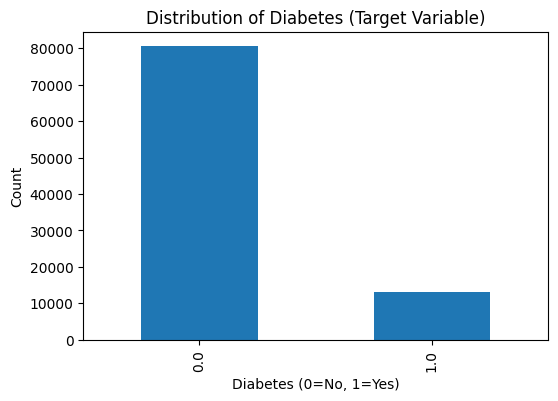

In [ ]:
import matplotlib.pyplot as plt

# Distribution of the target variable
plt.figure(figsize=(6, 4))
data['Diabetes_binary'].value_counts().plot(kind='bar')
plt.title('Distribution of Diabetes (Target Variable)')
plt.xlabel('Diabetes (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()



Correlation heatmap (for numerical features):To see the relationships between features and identify potential multicollinearity.

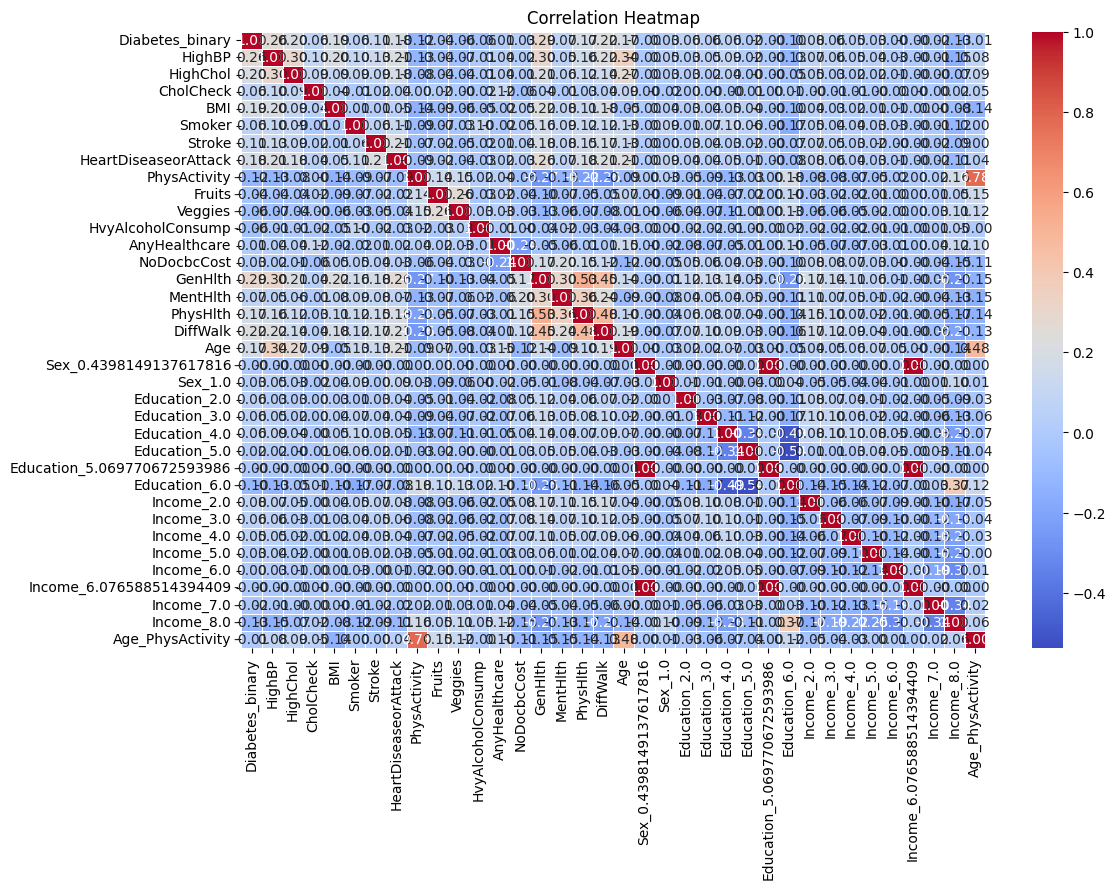

In [ ]:
import seaborn as sns

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
print(data.columns)


Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Sex_0.4398149137617816',
       'Sex_1.0', 'Education_2.0', 'Education_3.0', 'Education_4.0',
       'Education_5.0', 'Education_5.069770672593986', 'Education_6.0',
       'Income_2.0', 'Income_3.0', 'Income_4.0', 'Income_5.0', 'Income_6.0',
       'Income_6.076588514394409', 'Income_7.0', 'Income_8.0',
       'Age_PhysActivity'],
      dtype='object')


Boxplots to check for outliers:

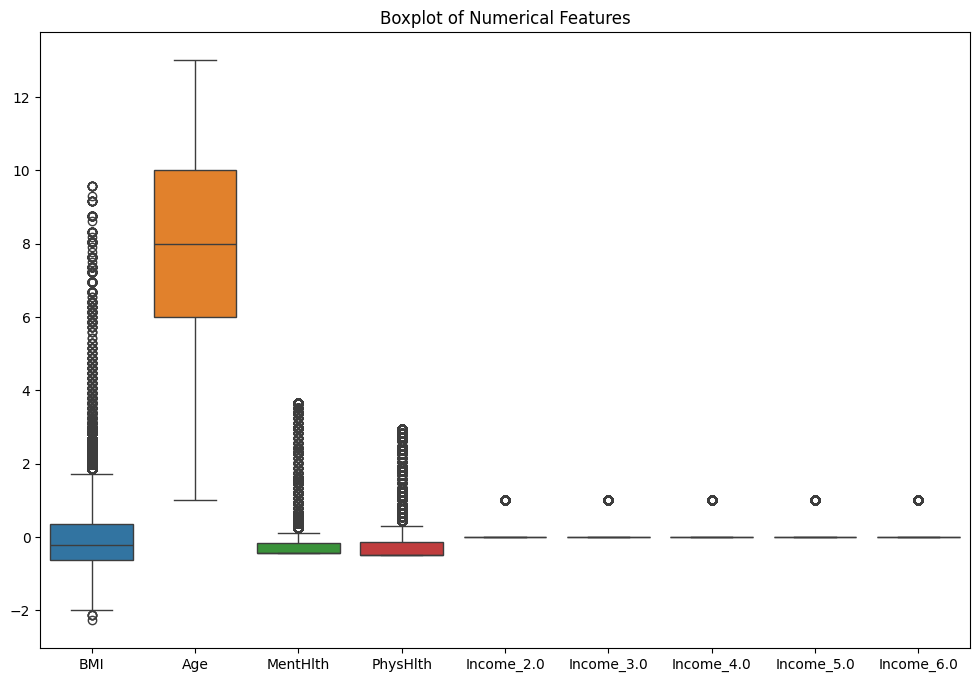

In [ ]:
# Boxplot for numerical features to check for outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[['BMI', 'Age', 'MentHlth', 'PhysHlth',
                       'Income_2.0', 'Income_3.0', 'Income_4.0', 'Income_5.0', 'Income_6.0']])
plt.title('Boxplot of Numerical Features')
plt.show()



Filtering out only the numerical columns dynamically and plot them without manually specifying the column names

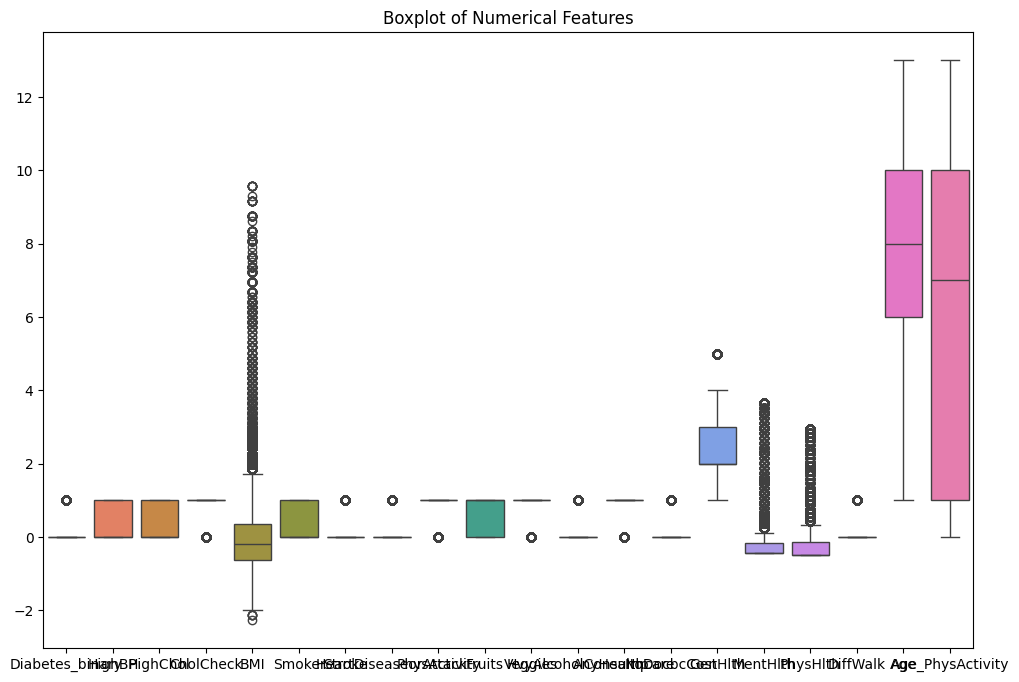

In [ ]:
# Filter out only numerical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Boxplot for all numerical features
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[numerical_cols])
plt.title('Boxplot of Numerical Features')
plt.show()


Visualizing the distribution of numerical features:

In [ ]:
# Distribution of numerical features
data[['BMI', 'Age', 'MentHlth', 'PhysHlth',
                       'Income_2.0', 'Income_3.0', 'Income_4.0', 'Income_5.0', 'Income_6.0']]
plt.suptitle('Distribution of Numerical Features')
plt.show()


<Figure size 640x480 with 0 Axes>

BIAS IN TERMS OF ACCURACY BY SEX:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Separate the target variable (Diabetes_binary) and features (all other columns)
X = data.drop(columns=['Diabetes_binary'])
y = data['Diabetes_binary']

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)  # max_iter to ensure convergence
model.fit(X_train, y_train)

# Generate predictions on the entire dataset (or on the test set)
data['prediction'] = model.predict(X)

# Check if the 'prediction' column has been added
print(data.columns)


Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Sex_0.4398149137617816',
       'Sex_1.0', 'Education_2.0', 'Education_3.0', 'Education_4.0',
       'Education_5.0', 'Education_5.069770672593986', 'Education_6.0',
       'Income_2.0', 'Income_3.0', 'Income_4.0', 'Income_5.0', 'Income_6.0',
       'Income_6.076588514394409', 'Income_7.0', 'Income_8.0',
       'Age_PhysActivity', 'prediction'],
      dtype='object')


In [ ]:
# List all column names and their exact text
for idx, col in enumerate(data.columns):
    print(f'{idx}: "{col}"')  # The quotes will show if there are hidden spaces


0: "Diabetes_binary"
1: "HighBP"
2: "HighChol"
3: "CholCheck"
4: "BMI"
5: "Smoker"
6: "Stroke"
7: "HeartDiseaseorAttack"
8: "PhysActivity"
9: "Fruits"
10: "Veggies"
11: "HvyAlcoholConsump"
12: "AnyHealthcare"
13: "NoDocbcCost"
14: "GenHlth"
15: "MentHlth"
16: "PhysHlth"
17: "DiffWalk"
18: "Age"
19: "Sex_0.4398149137617816"
20: "Sex_1.0"
21: "Education_2.0"
22: "Education_3.0"
23: "Education_4.0"
24: "Education_5.0"
25: "Education_5.069770672593986"
26: "Education_6.0"
27: "Income_2.0"
28: "Income_3.0"
29: "Income_4.0"
30: "Income_5.0"
31: "Income_6.0"
32: "Income_6.076588514394409"
33: "Income_7.0"
34: "Income_8.0"
35: "Age_PhysActivity"
36: "prediction"
37: "Sex"


In [ ]:
# Clean up column names by stripping extra spaces or special characters
data.columns = data.columns.str.strip()

# Now check if 'Diabetes_binary' can be accessed
print('Diabetes_binary' in data.columns)  # This should return True


True


In [ ]:
# Confirm the column exists before accessing it
print(data.columns)  # Check column names
print(data['Diabetes_binary'].head())  # Check the first few entries in the 'Diabetes_binary' column


Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Sex_0.4398149137617816',
       'Sex_1.0', 'Education_2.0', 'Education_3.0', 'Education_4.0',
       'Education_5.0', 'Education_5.069770672593986', 'Education_6.0',
       'Income_2.0', 'Income_3.0', 'Income_4.0', 'Income_5.0', 'Income_6.0',
       'Income_6.076588514394409', 'Income_7.0', 'Income_8.0',
       'Age_PhysActivity', 'prediction', 'Sex'],
      dtype='object')
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Diabetes_binary, dtype: float64


In [ ]:
# Check for null values in the column
print(data['Diabetes_binary'].isnull().sum())  # Number of null values in the column


0


In [ ]:
# Access the column using .loc
print(data.loc[:, 'Diabetes_binary'].head())


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Diabetes_binary, dtype: float64


In [ ]:
# Check the grouping column as well
print('Sex_0.4398149137617816' in data.columns)  # Ensure 'Sex' column exists


True


In [ ]:
from sklearn.metrics import precision_recall_curve

def ppr_by_group(group, target_column, prediction_column):
    # Calculate Precision-Recall curve
    y_true = group[target_column]  # True values
    y_pred = group[prediction_column]  # Predicted values

    # Compute precision and recall
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

    # Compute Average Precision (or you can choose another metric)
    avg_precision = sum(precision) / len(precision)

    return avg_precision


In [ ]:
# Assuming 'Sex' and other columns are correctly named
ppr_sex = data.groupby('Sex').apply(lambda x: ppr_by_group(x, 'Diabetes_binary', 'prediction'))


<ipython-input-59-39806110cede>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ppr_sex = data.groupby('Sex').apply(lambda x: ppr_by_group(x, 'Diabetes_binary', 'prediction'))


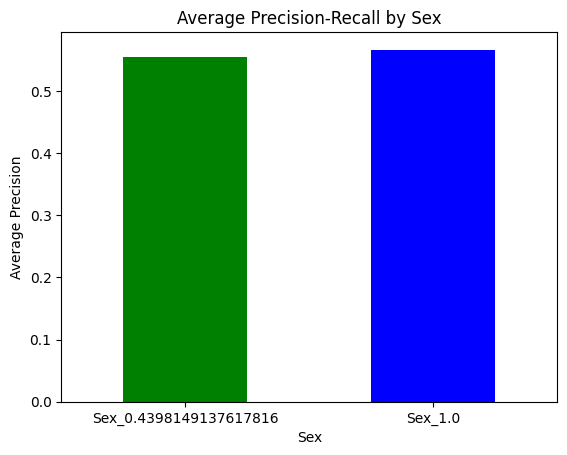

In [ ]:
# Plotting the results of PPR by Sex
import matplotlib.pyplot as plt

ppr_sex.plot(kind='bar', color=['green', 'blue'])
plt.title('Average Precision-Recall by Sex')
plt.xlabel('Sex')
plt.ylabel('Average Precision')
plt.xticks(rotation=0)
plt.show()


Bias Mitigation

In [ ]:
# Perform one-hot encoding on the 'Sex' column (and other categorical columns if needed)
X = pd.get_dummies(data.drop(columns=['Diabetes_binary', 'prediction']), drop_first=True)



In [ ]:
# Ensure 'weight' is of type float
data['weight'] = data['weight'].astype(float)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Reweight the data based on the bias mitigation strategy
data['weight'] = 1  # Default weight
data.loc[data['Sex'] == 'Male', 'weight'] = 1.2  # Example of changing weights

# Ensure 'weight' column is float type
data['weight'] = data['weight'].astype(float)

# One-hot encode categorical features (like 'Sex')
X = pd.get_dummies(data.drop(columns=['Diabetes_binary', 'prediction']), drop_first=True)
y = data['Diabetes_binary']  # Target

# Split into train and test sets
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, data['weight'], test_size=0.2)

# Train RandomForest with weights
model = RandomForestClassifier()
model.fit(X_train, y_train, sample_weight=w_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate accuracy
print('Accuracy with reweighting:', accuracy_score(y_test, predictions))


<ipython-input-66-f46b33f1bca3>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['Sex'] == 'Male', 'weight'] = 1.2  # Example of changing weights


Accuracy with reweighting: 0.8646612524043599


Comparing Models (With and Without Mitigation)

ORIGINAL MODEL (WITHOUT MITIGATION):-

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the original model on the test set
original_predictions = model.predict(X_test)  # Assuming `model` is the trained original model

# Calculate metrics for the original model
original_accuracy = accuracy_score(y_test, original_predictions)
original_precision = precision_score(y_test, original_predictions)
original_recall = recall_score(y_test, original_predictions)
original_f1 = f1_score(y_test, original_predictions)



Reweighted Model (With Bias Mitigation)

In [ ]:
# Evaluate the reweighted model on the test set
reweighted_predictions = model.predict(X_test)  # Assuming `model` is the trained reweighted model

# Calculate metrics for the reweighted model
reweighted_accuracy = accuracy_score(y_test, reweighted_predictions)
reweighted_precision = precision_score(y_test, reweighted_predictions)
reweighted_recall = recall_score(y_test, reweighted_predictions)
reweighted_f1 = f1_score(y_test, reweighted_predictions)


Plotting the Comparison

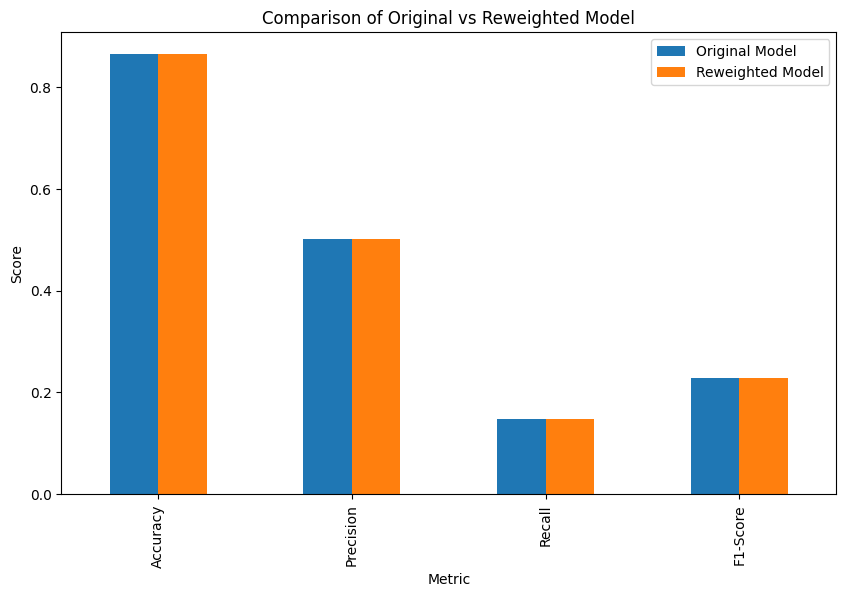

In [ ]:
import matplotlib.pyplot as plt

# Create comparison data frame
metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Original Model': [original_accuracy, original_precision, original_recall, original_f1],
    'Reweighted Model': [reweighted_accuracy, reweighted_precision, reweighted_recall, reweighted_f1]
})

# Plot comparison
metrics_comparison.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Original vs Reweighted Model')
plt.ylabel('Score')
plt.show()


Final Visualizations

Confusion Matrix (for original and reweighted models)

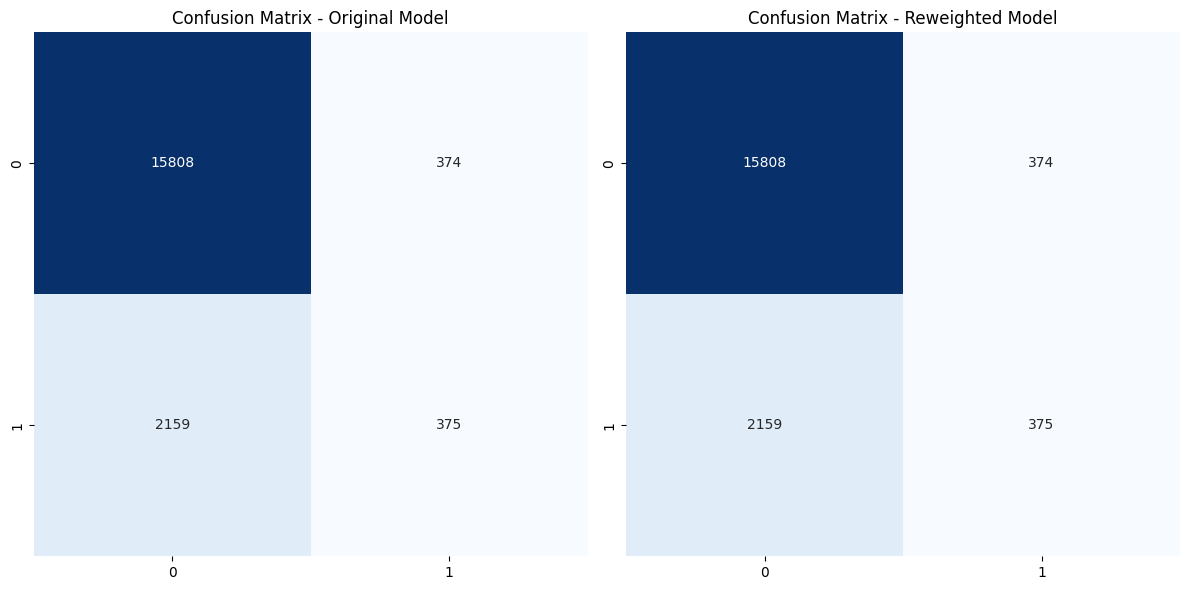

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix for the original model
cm_original = confusion_matrix(y_test, original_predictions)

# Confusion matrix for the reweighted model
cm_reweighted = confusion_matrix(y_test, reweighted_predictions)

# Plot confusion matrix for both models
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Original Model')

plt.subplot(1, 2, 2)
sns.heatmap(cm_reweighted, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Reweighted Model')

plt.tight_layout()
plt.show()


Bar Plot of Bias Mitigation Impact

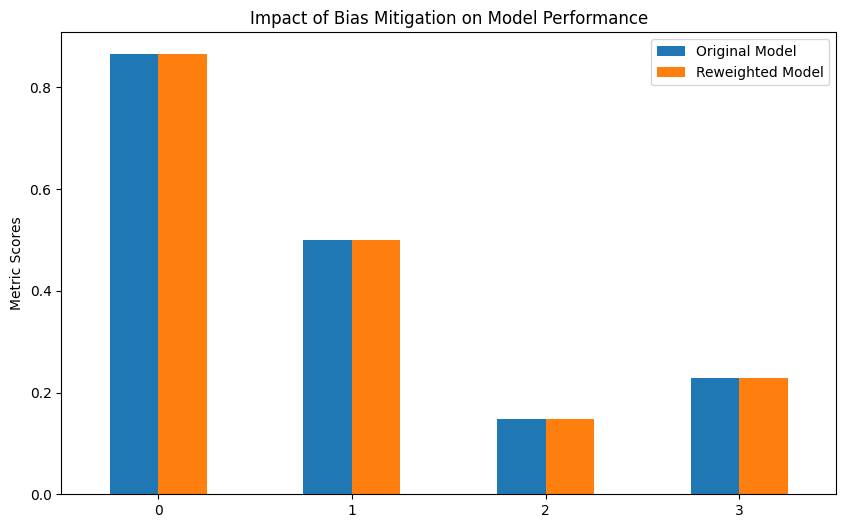

In [ ]:
# Plot bar graph comparing impact of mitigation (before vs after)
metrics_comparison.plot(kind='bar', figsize=(10, 6))
plt.title('Impact of Bias Mitigation on Model Performance')
plt.ylabel('Metric Scores')
plt.xticks(rotation=0)
plt.show()


Missing Values Analysis

In [ ]:
# Check for missing values
missing_data = data.isnull().sum()
missing_data_percentage = (missing_data / len(data)) * 100
print(missing_data_percentage)


Diabetes_binary                0.0
HighBP                         0.0
HighChol                       0.0
CholCheck                      0.0
BMI                            0.0
Smoker                         0.0
Stroke                         0.0
HeartDiseaseorAttack           0.0
PhysActivity                   0.0
Fruits                         0.0
Veggies                        0.0
HvyAlcoholConsump              0.0
AnyHealthcare                  0.0
NoDocbcCost                    0.0
GenHlth                        0.0
MentHlth                       0.0
PhysHlth                       0.0
DiffWalk                       0.0
Age                            0.0
Sex_0.4398149137617816         0.0
Sex_1.0                        0.0
Education_2.0                  0.0
Education_3.0                  0.0
Education_4.0                  0.0
Education_5.0                  0.0
Education_5.069770672593986    0.0
Education_6.0                  0.0
Income_2.0                     0.0
Income_3.0          

<Axes: >

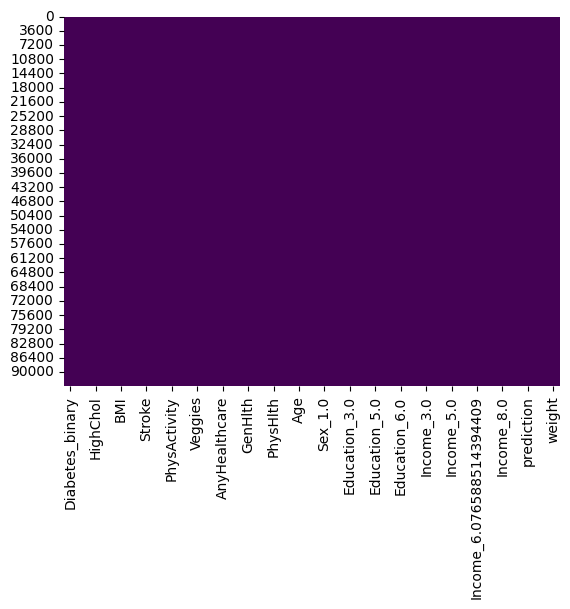

In [ ]:
import seaborn as sns
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')


Outlier Detection

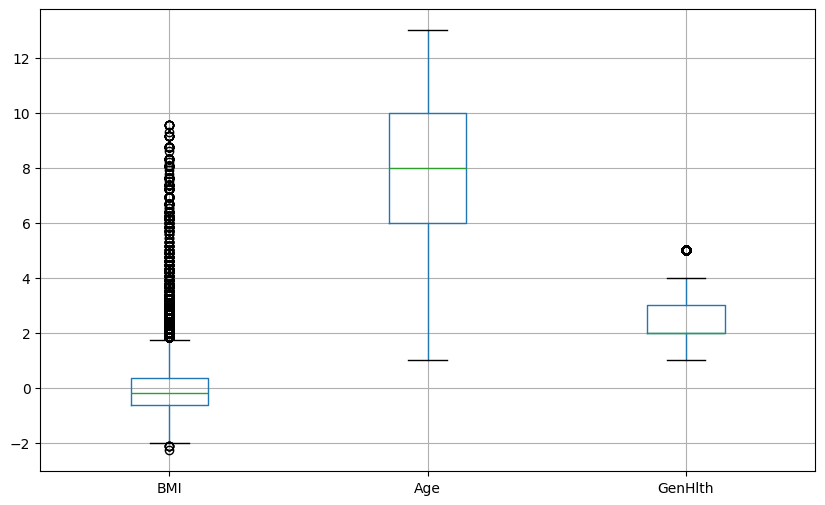

In [ ]:
# Boxplot for detecting outliers in numerical columns
data[['BMI', 'Age', 'GenHlth']].boxplot(figsize=(10, 6))
plt.show()


Correlation Heatmap

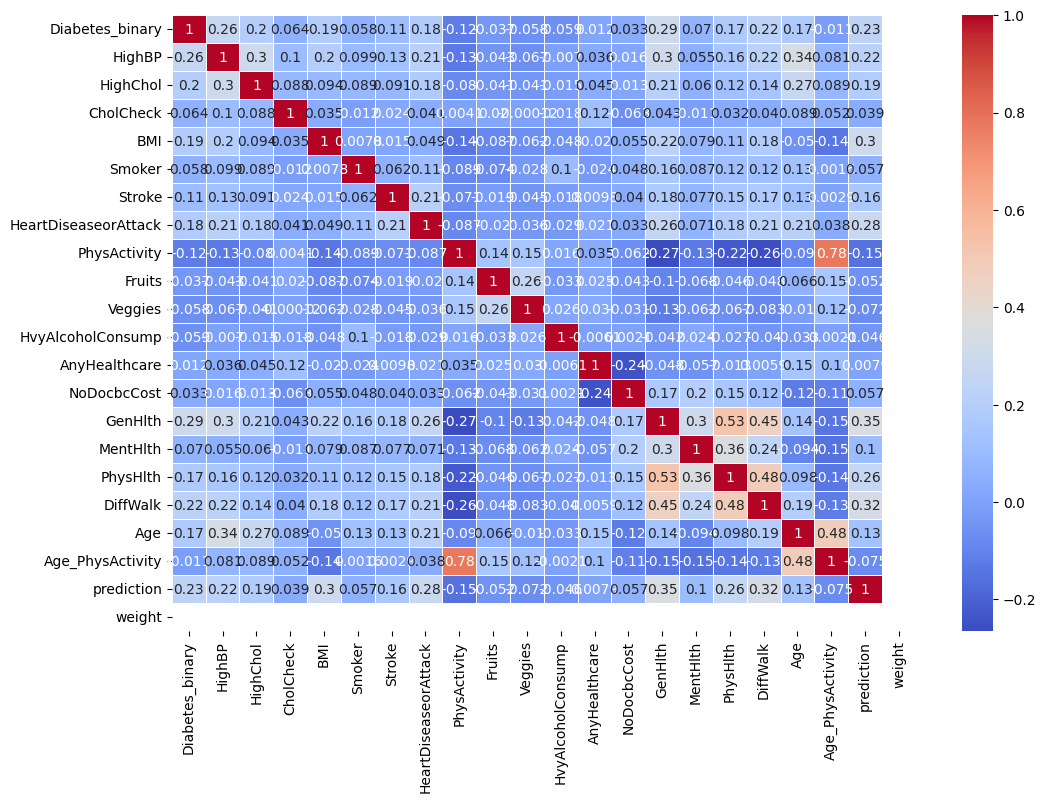

In [ ]:
# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=[float, int])

# Calculate correlation matrix for numeric columns
corr_matrix = numeric_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


Feature Distribution

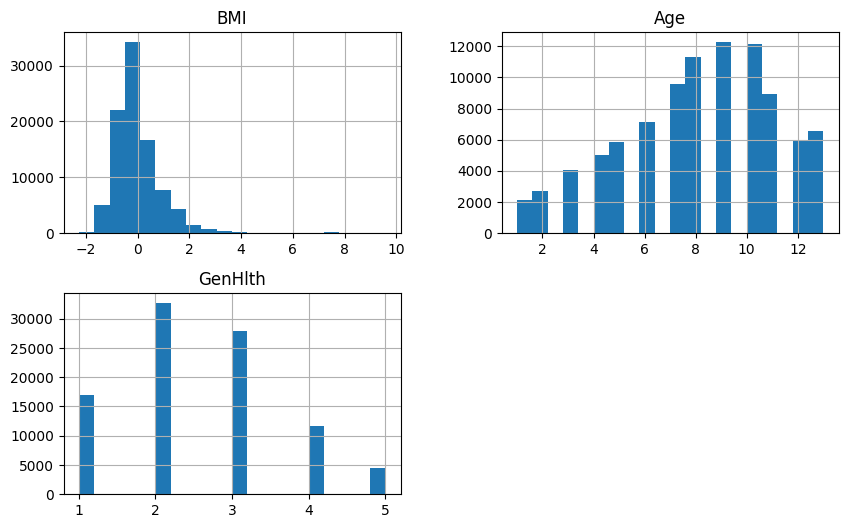

In [ ]:
# Plot histograms for numerical features
data[['BMI', 'Age', 'GenHlth']].hist(bins=20, figsize=(10, 6))
plt.show()


Class Imbalance Check

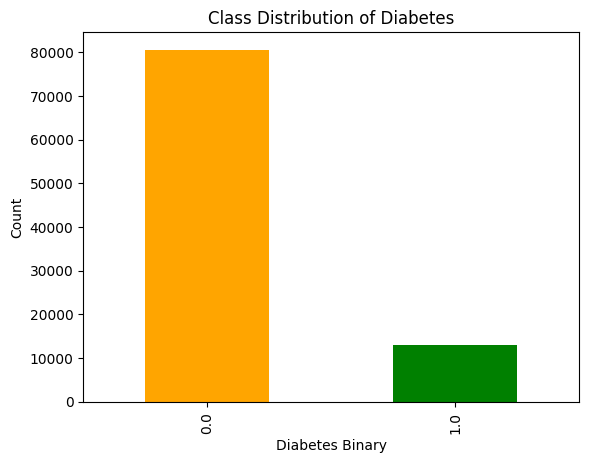

In [ ]:
data['Diabetes_binary'].value_counts().plot(kind='bar', color=['orange', 'green'])
plt.title('Class Distribution of Diabetes')
plt.xlabel('Diabetes Binary')
plt.ylabel('Count')
plt.show()


Relationship Between Features and Target

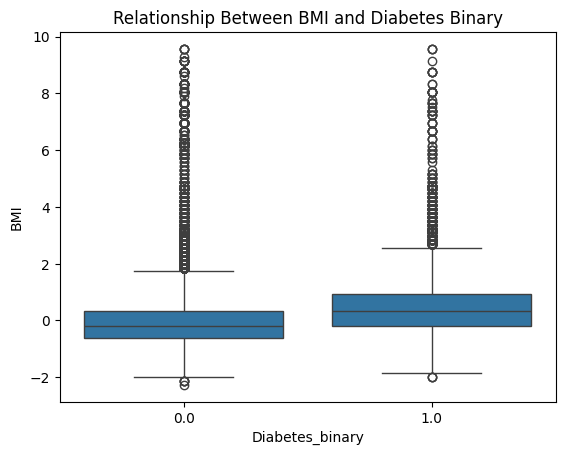

In [ ]:
# Boxplot to check the relationship between BMI and Diabetes
sns.boxplot(x='Diabetes_binary', y='BMI', data=data)
plt.title('Relationship Between BMI and Diabetes Binary')
plt.show()


Class-wise Feature Impact (Bias Analysis)

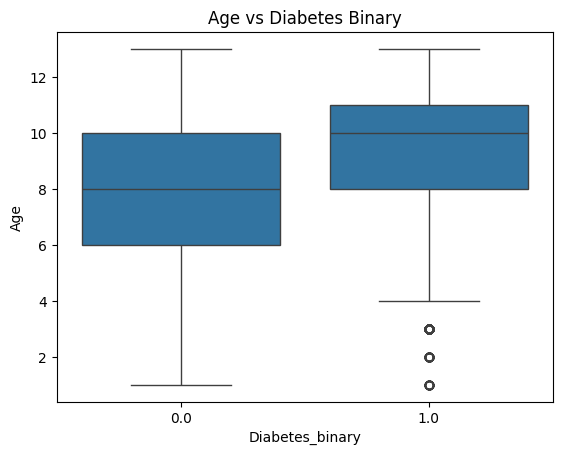

In [ ]:
# Example: Plotting Age vs Diabetes Binary
sns.boxplot(x='Diabetes_binary', y='Age', data=data)
plt.title('Age vs Diabetes Binary')
plt.show()


Pairplot for Correlations and Clusters

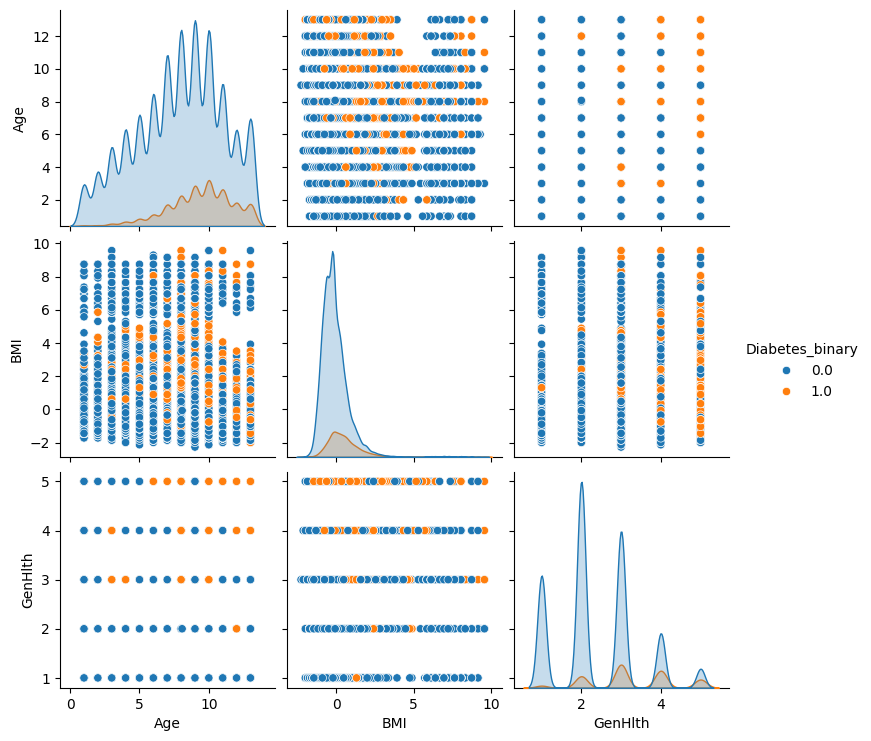

In [ ]:
sns.pairplot(data[['Age', 'BMI', 'GenHlth', 'Diabetes_binary']], hue='Diabetes_binary')
plt.show()


Outlier Detection:

In [ ]:
# Detect outliers using Z-score
from scipy import stats
z_scores = stats.zscore(numeric_data)
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3).all(axis=1)
print(f'Outliers: {outliers}')


Outliers: 0        False
1        False
2        False
3        False
4        False
         ...  
93574    False
93575    False
93576    False
93577    False
93578    False
Length: 93579, dtype: bool
